## Install necessary libraries

In [1]:
!pip install memory_profiler
!pip install opendatasets
!pip install pandas
!pip install tensorflow


# Import required libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import opendatasets as od
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score



# Download the dataset (replace the URL with your dataset's Kaggle URL)

In [3]:

od.download("https://www.kaggle.com/datasets/cybersimar08/casia-face-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alphasnow
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/cybersimar08/casia-face-dataset


100%|██████████| 52.2M/52.2M [00:00<00:00, 82.1MB/s]


In [4]:
dataset_path = '/content/casia-face-dataset/casia dataset'
if os.path.exists(dataset_path):
    print("Dataset directory loaded successfully.")
else:
    print("Error: Dataset directory not found!")


Dataset directory loaded successfully.


# Dataset

In [5]:
# Explore the dataset
subject_folders = os.listdir(dataset_path)
print(f"Total number of subjects: {len(subject_folders)}")
print(f"Example subject folders: {subject_folders[:5]}")

Total number of subjects: 200
Example subject folders: ['000038', '000136', '000039', '000521', '000444']


In [6]:
# Load and display a sample image
sample_folder = os.path.join(dataset_path, subject_folders[0])
image_files = os.listdir(sample_folder)
sample_image_path = os.path.join(sample_folder, image_files[0])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_COLOR)
print(f"Sample image shape: {sample_image.shape}")


Sample image shape: (112, 112, 3)


#resize dataset

In [7]:
IMG_SIZE = (64, 64)
images, labels = [], []
label_map = {folder: idx for idx, folder in enumerate(subject_folders)}

for folder in subject_folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:  # Ensure the image is valid
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(label_map[folder])

print(f"Loaded {len(images)} images.")





Loaded 20197 images.


#normalize dataset

In [8]:
normalized_images = []
for img in images:
    img = img.astype(np.float32)
    mean_per_channel = np.mean(img, axis=(0, 1))
    img_centered = img - mean_per_channel
    std_per_channel = np.std(img, axis=(0, 1))
    normalized_image = img_centered / (std_per_channel + 1e-7)
    normalized_images.append(normalized_image)
normalized_images = np.array(normalized_images)
print(f"Normalized images shape: {normalized_images.shape}")


Normalized images shape: (20197, 64, 64, 3)


#Divide dataset into train, validation, and test sets (70%, 15%, 15%)

In [9]:
from sklearn.model_selection import train_test_split

TrainingImages, TempImages, TrainingLabels, TempLabels = train_test_split(
    normalized_images, labels, test_size=0.3, random_state=42, stratify=labels
)
TestingImages, ValidationImages, TestingLabels, ValidationLabels = train_test_split(
    TempImages, TempLabels, test_size=0.5, random_state=42, stratify=TempLabels
)


In [10]:
np.savez_compressed('./casia_preprocessed_data_100x100.npz',
                    TrainingImages=TrainingImages, TrainingLabels=TrainingLabels,
                    ValidationImages=ValidationImages, ValidationLabels=ValidationLabels,
                    TestingImages=TestingImages, TestingLabels=TestingLabels)
print("Data saved successfully!")

Data saved successfully!


#dataset

In [11]:
data = np.load('./casia_preprocessed_data_100x100.npz')
TrainingImages = data['TrainingImages']
TrainingLabels = data['TrainingLabels']
ValidationImages = data['ValidationImages']
ValidationLabels = data['ValidationLabels']
TestingImages = data['TestingImages']
TestingLabels = data['TestingLabels']


In [12]:
TrainingImages_flat = TrainingImages.reshape(TrainingImages.shape[0], -1).astype('float32')
ValidationImages_flat = ValidationImages.reshape(ValidationImages.shape[0], -1).astype('float32')
TestingImages_flat = TestingImages.reshape(TestingImages.shape[0], -1).astype('float32')


In [13]:
print(f"Training images shape: {TrainingImages.shape}")
print(f"Validation images shape: {ValidationImages.shape}")
print(f"Testing images shape: {TestingImages.shape}")



Training images shape: (14137, 64, 64, 3)
Validation images shape: (3030, 64, 64, 3)
Testing images shape: (3030, 64, 64, 3)


#showing sample of normalized images

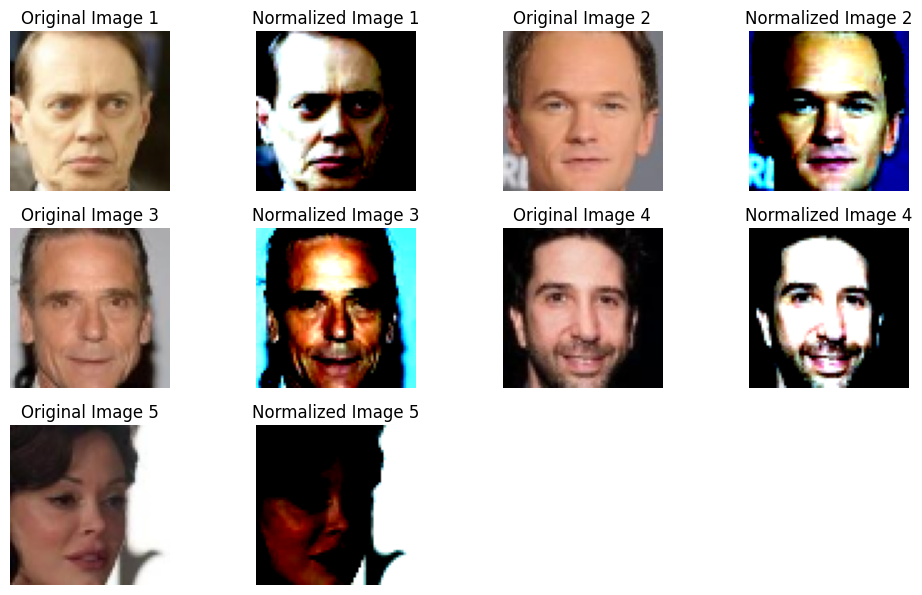

In [14]:
import matplotlib.pyplot as plt
import random

# Select 10 random indices from the images list
random_indices = random.sample(range(len(images)), 5)

# Create a figure to display the images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices):
    # Original image (before normalization)
    original_image = images[idx]

    # Normalized image
    normalized_image = normalized_images[idx]

    # Plot original image
    plt.subplot(5, 4, i * 2 + 1)
    plt.imshow(original_image)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Plot normalized image
    plt.subplot(5, 4, i * 2 + 2)
    plt.imshow(normalized_image)
    plt.title(f"Normalized Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#Vanila Autoencoder

In [15]:
# Constants
BOTTLE_NECK_DIM = 64
BATCH_SIZE = 16
EPOCHS = 20

# Build Autoencoder Model
def build_autoencoder(input_shape):
    # Encoder
    input_layer = tf.keras.Input(shape=(input_shape,))
    encoded_1 = tf.keras.layers.Dense(128, activation='linear')(input_layer)
    encoded_2 = tf.keras.layers.Dense(64, activation='linear')(encoded_1)
    latent_space = tf.keras.layers.Dense(BOTTLE_NECK_DIM, activation='linear')(encoded_2)

    # Decoder
    decoded_1 = tf.keras.layers.Dense(64, activation='linear')(latent_space)
    decoded_2 = tf.keras.layers.Dense(128, activation='linear')(decoded_1)
    output_layer = tf.keras.layers.Dense(input_shape, activation='linear')(decoded_2)

    # Models
    encoder = tf.keras.Model(inputs=input_layer, outputs=latent_space)
    decoder = tf.keras.Model(inputs=latent_space, outputs=output_layer)
    autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder, decoder
    encoder.summary()
    decoder.summary()
    autoencoder.summary()


#train function

In [16]:
# Train Model
def train_autoencoder(model, train_data, val_data):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_data[0], train_data[0],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_data[0], val_data[0]),
        callbacks=[early_stopping]
    )
    return history


#plot training history function




In [17]:
# Plot Training History
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


#training Vanila autoencoder


Training the autoencoder...
Epoch 1/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3990 - val_loss: 0.2010
Epoch 2/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1943 - val_loss: 0.1823
Epoch 3/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1792 - val_loss: 0.1736
Epoch 4/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1743 - val_loss: 0.1710
Epoch 5/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1724 - val_loss: 0.1747
Epoch 6/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1702 - val_loss: 0.1686
Epoch 7/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1693 - val_loss: 0.1648
Epoch 8/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1657 - val_loss: 0.1654
Epoch 9/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1655 - val_loss: 0.1632
Epoch 10/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1643 - val_loss: 0.1650
Epoch 11/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1644 - val_loss: 0.1625
Epoch 12/20
884/884 ━━━━

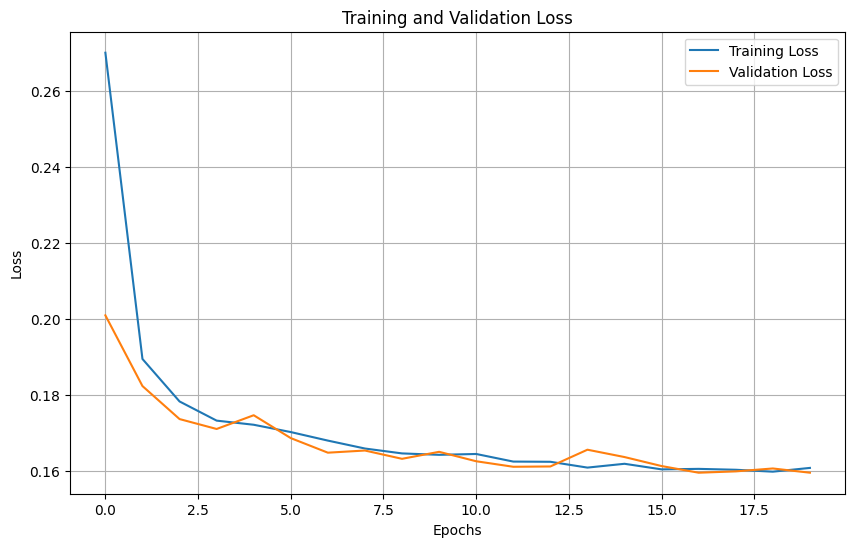

In [18]:
# Build and compile the autoencoder model
autoencoder, encoder, decoder = build_autoencoder(TrainingImages_flat.shape[1])

# Train the model
print("Training the autoencoder...")
history = train_autoencoder(autoencoder, (TrainingImages_flat, TrainingLabels), (ValidationImages_flat, ValidationLabels))

# Plot the training and validation loss
plot_history(history)



#cross validation (vanila autoencoder)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

# Constants
K_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 10

# Define architectures
architectures = [
    {"layers": [128, 64], "bottleneck": 32},  # Architecture 1
    {"layers": [256, 128], "bottleneck": 64},  # Architecture 2
    {"layers": [512, 256, 128], "bottleneck": 128},  # Architecture 3
]

# Build Autoencoder Model for Given Architecture
def build_autoencoder(input_shape, layers, bottleneck):
    # Encoder
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for units in layers:
        x = tf.keras.layers.Dense(units, activation='linear')(x)
    latent_space = tf.keras.layers.Dense(bottleneck, activation='linear')(x)

    # Decoder
    x = latent_space
    for units in reversed(layers):
        x = tf.keras.layers.Dense(units, activation='linear')(x)
    output_layer = tf.keras.layers.Dense(input_shape, activation='linear')(x)

    # Models
    autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Perform K-Fold Cross-Validation
def cross_validate_autoencoder(TrainingImages_flat, architectures, k_folds=K_FOLDS):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    input_shape = TrainingImages_flat.shape[1]
    results = []

    for arch_idx, arch in enumerate(architectures):
        print(f"\nEvaluating Architecture {arch_idx + 1}: {arch}")
        fold_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(TrainingImages_flat)):
            print(f"  Fold {fold + 1}/{k_folds}")
            train_data = TrainingImages_flat[train_idx]
            val_data = TrainingImages_flat[val_idx]

            # Build model
            autoencoder = build_autoencoder(input_shape, arch["layers"], arch["bottleneck"])

            # Train model
            history = autoencoder.fit(
                train_data, train_data,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(val_data, val_data),
                verbose=0  # Suppress detailed logs
            )

            # Record validation loss
            fold_loss = history.history['val_loss'][-1]
            fold_losses.append(fold_loss)
            print(f"    Fold {fold + 1} Validation Loss: {fold_loss:.4f}")

        # Average loss for this architecture
        avg_loss = np.mean(fold_losses)
        results.append({"architecture": arch, "avg_loss": avg_loss})
        print(f"  Architecture {arch_idx + 1} Average Loss: {avg_loss:.4f}")

    return results

# Perform cross-validation
results = cross_validate_autoencoder(TrainingImages_flat, architectures)

# Print results
print("\nCross-Validation Results:")
for idx, res in enumerate(results):
    print(f"Architecture {idx + 1}: {res['architecture']}, Average Loss: {res['avg_loss']:.4f}")



Evaluating Architecture 1: {'layers': [128, 64], 'bottleneck': 32}
  Fold 1/5
    Fold 1 Validation Loss: 0.2203
  Fold 2/5
    Fold 2 Validation Loss: 0.2202
  Fold 3/5
    Fold 3 Validation Loss: 0.2181
  Fold 4/5
    Fold 4 Validation Loss: 0.2212
  Fold 5/5
    Fold 5 Validation Loss: 0.2200
  Architecture 1 Average Loss: 0.2200

Evaluating Architecture 2: {'layers': [256, 128], 'bottleneck': 64}
  Fold 1/5
    Fold 1 Validation Loss: 0.1635
  Fold 2/5
    Fold 2 Validation Loss: 0.1624
  Fold 3/5
    Fold 3 Validation Loss: 0.1620
  Fold 4/5
    Fold 4 Validation Loss: 0.1682
  Fold 5/5
    Fold 5 Validation Loss: 0.1607
  Architecture 2 Average Loss: 0.1634

Evaluating Architecture 3: {'layers': [512, 256, 128], 'bottleneck': 128}
  Fold 1/5
    Fold 1 Validation Loss: 0.1290
  Fold 2/5
    Fold 2 Validation Loss: 0.1316
  Fold 3/5
    Fold 3 Validation Loss: 0.1373
  Fold 4/5
    Fold 4 Validation Loss: 0.1255
  Fold 5/5
    Fold 5 Validation Loss: 0.1271
  Architecture 3 Avera

#minimum Euclidean distance classifier

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cdist

# Step 1: Train the autoencoder with Architecture 3
best_architecture = {"layers": [512, 256, 128], "bottleneck": 128}  # Best architecture
input_shape = TrainingImages_flat.shape[1]

# Build and train the autoencoder
autoencoder = build_autoencoder(input_shape, best_architecture["layers"], best_architecture["bottleneck"])
history = autoencoder.fit(
    TrainingImages_flat, TrainingImages_flat,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(ValidationImages_flat, ValidationImages_flat),
    verbose=1
)

# Step 2: Extract encoder from the trained autoencoder
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(best_architecture["layers"]) + 1].output)

# Step 3: Extract latent features
train_features = encoder.predict(TrainingImages_flat)
test_features = encoder.predict(TestingImages_flat)

# Step 4: Minimum Euclidean Distance Classifier
distances = cdist(test_features, train_features, metric='euclidean')
predicted_labels = [TrainingLabels[np.argmin(dist)] for dist in distances]

# Step 5: Compute recognition accuracy
accuracy = accuracy_score(TestingLabels, predicted_labels)
print(f"Recognition Accuracy using Minimum Euclidean Distance Classifier: {accuracy * 100:.2f}%")



Epoch 1/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8640 - val_loss: 0.1989
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1877 - val_loss: 0.1587
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1542 - val_loss: 0.1433
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1408 - val_loss: 0.1367
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1337 - val_loss: 0.1311
Epoch 6/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1294 - val_loss: 0.1285
Epoch 7/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1261 - val_loss: 0.1301
Epoch 8/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1304 - val_loss: 0.1264
Epoch 9/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1275 - val_loss: 0.1276
Epoch 10/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1310 - val_loss: 0.1362
Epoch 11/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1303 - val_loss: 0.1286
Epoch 12/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/ste

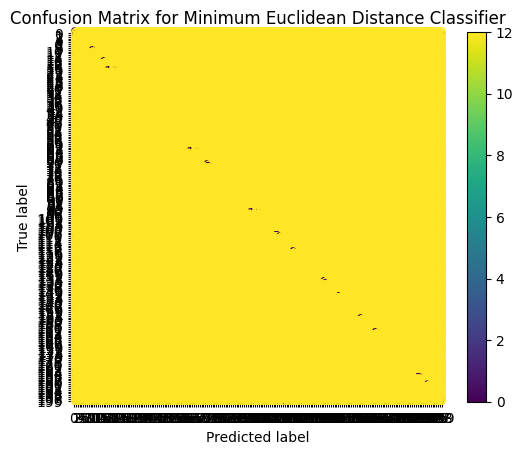

True classes: [ 33  70  31 ... 117  15  51]
Predicted classes: [ 33 110  97 ...  12  19 178]
Unique true classes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Unique predicted classes: [  0   1   2   3   4   5   6   7   8   9  10  1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Ensure inline plots
%matplotlib inline

# Function to calculate and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, num_classes, optimizer_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap='viridis')  # Set colormap for better visualization
    plt.title(f"Confusion Matrix for {optimizer_name}")
    plt.show()

# Assuming you have already trained your autoencoder and extracted features
# and you have the predicted labels from the minimum Euclidean distance classifier

# Convert true labels and predicted labels to class labels if they are one-hot encoded
# If your labels are not one-hot encoded, you can skip this step
if len(TestingLabels.shape) > 1:  # Check if one-hot encoded
    y_true_classes = np.argmax(TestingLabels, axis=1)  # Convert to class indices
else:
    y_true_classes = TestingLabels  # Already in class index format

# Ensure predicted_labels is in the same format
y_pred_classes = np.array(predicted_labels)  # Your predicted labels

# Example usage
num_classes = len(np.unique(y_true_classes))  # Get the number of unique classes
optimizer_name = "Minimum Euclidean Distance Classifier"  # Name of the classifier

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, num_classes, optimizer_name)

print("True classes:", y_true_classes)
print("Predicted classes:", y_pred_classes)
print("Unique true classes:", np.unique(y_true_classes))
print("Unique predicted classes:", np.unique(y_pred_classes))